<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/FunAPI_tf2_mnist_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar base de datos MNIST

In [0]:
#librerias principales
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #wrapper keras sklearn
import tensorflow_probability as tfp

In [2]:
#cargar datos
(Xtrain, ytrain), (Xtest, ytest) = tf.keras.datasets.mnist.load_data()
Xtrain = Xtrain/255 #obligar a flotante normalizado 0 a 1
Xtest = Xtest/255
print(Xtrain.shape, Xtest.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


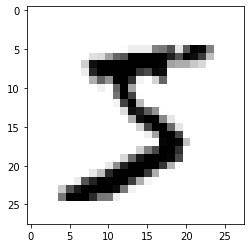

In [3]:
plt.imshow(Xtrain[0],cmap='binary')

# Generar dos tipos de entrada y dos tipos de salida

Valores etiquetas: [0 1 2 3 4 5 6 7 8 9]


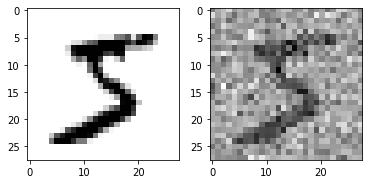

In [4]:
#agregar salida extra
print('Valores etiquetas:',np.unique(ytrain))
ytrainB = np.zeros((ytrain.shape[0]))
ytestB = np.zeros((ytest.shape[0]))
ytrainB[ytrain % 2 == 0] = 1 #salida divisor de 2
ytestB[ytest % 2 == 0] = 1 #salida divisor de 2

#agregar entrada extra 
var = 0.1 #varianza ruido
XtrainB = Xtrain + np.sqrt(var)*np.random.randn(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2])
XtestB = Xtest + np.sqrt(var)*np.random.randn(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2])

#ejemplo entrada con y sin ruido
fig, ax = plt.subplots(1,2)
fig.figsize = (4,4)
ax[0].imshow(Xtrain[0],cmap='binary')
ax[1].imshow(XtrainB[0],cmap='binary')
plt.show()


# Arquitectura por api funcional

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           entradaA[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           entradaB[0][0]                   
______________________________________________________________________________________________

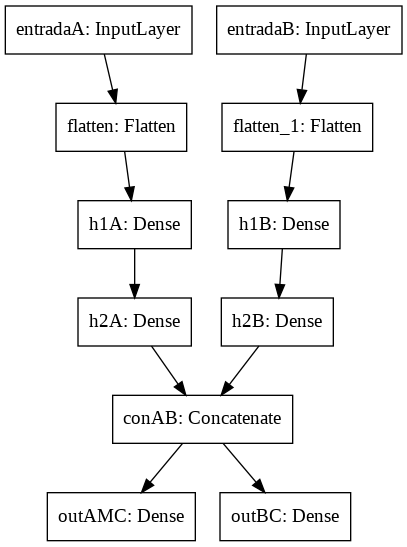

In [5]:
#ejemplo secuencial
'''
#definir arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="tanh",name='hred2'),
    tf.keras.layers.Dense(10,activation='softmax',name='output')
])

model.summary()
tf.keras.utils.plot_model(model)
'''

#ejemplo funcional
tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2]), name='entradaB')
Q1 = 100
Q2 = 20
l1 = 1e-3
l2 = 1e-3
flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(inputB)

h1A = tf.keras.layers.Dense(Q1,activation='tanh',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(Q2,activation='tanh',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)

h2A = tf.keras.layers.Dense(Q2,activation='tanh',name='h2A',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1A)
h2B = tf.keras.layers.Dense(Q2,activation='tanh',name='h2B',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1B)

concAB = tf.keras.layers.concatenate([h2A,h2B],name='conAB')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concAB) #salida multiclase
outputB = tf.keras.layers.Dense(1,activation="sigmoid",name='outBC')(concAB) #salida biclase
model_fun = tf.keras.Model(inputs=[inputA,inputB],outputs=[outputA,outputB])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [6]:
#compilar modelo y entrenar

model_fun.compile(loss=["sparse_categorical_crossentropy",tf.keras.losses.BinaryCrossentropy()], #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              loss_weights = [0.5,0.5],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =[Xtrain,XtrainB], y=[ytrain,ytrainB], 
                        epochs=30,batch_size=64, # 32, 64, 128, 256
                         validation_split=0.3)


Epoch 1/30
657/657 [==============================] - 5s 7ms/step - loss: 1.2348 - outAMC_loss: 0.6250 - outBC_loss: 0.3072 - outAMC_accuracy: 0.8443 - outBC_accuracy: 0.8760 - val_loss: 0.6998 - val_outAMC_loss: 0.4704 - val_outBC_loss: 0.2690 - val_outAMC_accuracy: 0.8700 - val_outBC_accuracy: 0.8921
Epoch 2/30
657/657 [==============================] - 4s 6ms/step - loss: 0.6073 - outAMC_loss: 0.4253 - outBC_loss: 0.2137 - outAMC_accuracy: 0.8861 - outBC_accuracy: 0.9206 - val_loss: 0.5630 - val_outAMC_loss: 0.4058 - val_outBC_loss: 0.2100 - val_outAMC_accuracy: 0.8846 - val_outBC_accuracy: 0.9224
Epoch 3/30
657/657 [==============================] - 4s 6ms/step - loss: 0.5044 - outAMC_loss: 0.3683 - outBC_loss: 0.1674 - outAMC_accuracy: 0.8998 - outBC_accuracy: 0.9404 - val_loss: 0.4850 - val_outAMC_loss: 0.3647 - val_outBC_loss: 0.1575 - val_outAMC_accuracy: 0.9007 - val_outBC_accuracy: 0.9444
Epoch 4/30
657/657 [==============================] - 4s 6ms/step - loss: 0.4565 - outAM

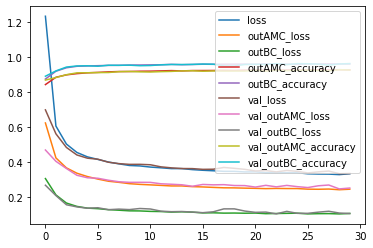

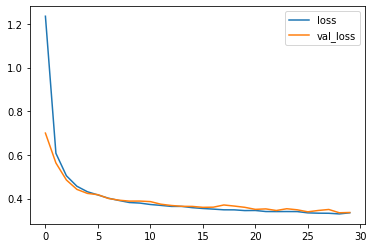

In [7]:
#graficar historial convergencia
import pandas as pd
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

In [0]:
#matriz de confusion
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

(10000, 10)
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.95      0.92      0.93      1032
           3       0.93      0.91      0.92      1010
           4       0.93      0.92      0.93       982
           5       0.90      0.89      0.89       892
           6       0.91      0.96      0.93       958
           7       0.95      0.92      0.93      1028
           8       0.91      0.90      0.91       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

(10000, 1)
[0. 1.]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      5074
         1.0       0.96      0.97      0.97      4926

    accuracy                           0.97   

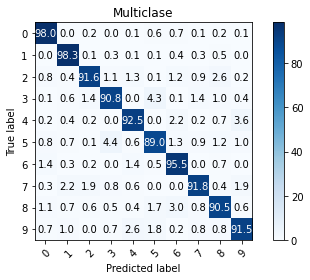

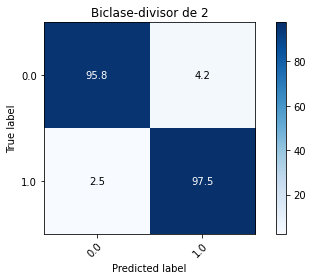

In [9]:
#conjunto de test 
ytest_e,ytest_eB = model_fun.predict([Xtest,XtestB])
print(ytest_e.shape)
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=np.unique(ytest))
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))

print(ytest_eB.shape)
print(np.unique(np.round(ytest_eB)))
plot_confusion_matrix(ytestB, np.round(ytest_eB),classes=np.unique(ytestB))
plt.title('Biclase-divisor de 2')
print(classification_report(ytestB, np.round(ytest_eB)))




2 [[1.]]


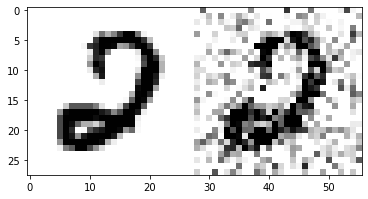

In [10]:
ii = 400
pe,peb = model_fun.predict([Xtest[ii][np.newaxis,:,:],XtestB[ii][np.newaxis,:,:]])
print(pe.argmax(),np.round(peb))
plt.imshow(np.c_[Xtest[ii],XtestB[ii]],cmap='binary',vmin=0,vmax=1)
plt.show()

# Interpretar pesos red

In [11]:
model_fun.get_layer('h1A').name
#model_fun.layers[5].name


'h1A'

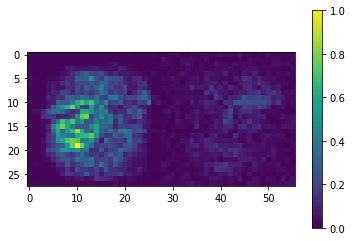

In [12]:
W1 = abs(model_fun.get_layer('h1A').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
W2 = abs(model_fun.get_layer('h1B').get_weights()[0]).sum(axis=1).reshape(Xtest.shape[1],Xtest.shape[2])
Wc = np.c_[W1,W2]
Wc /=np.max(Wc)
plt.imshow(Wc,vmin=0,vmax=1)
plt.colorbar()
plt.show()


# Función de perdida propia

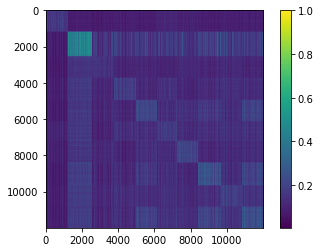

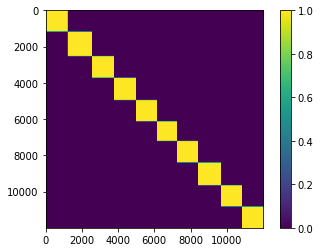

(12000, 12000)


In [13]:
#ejmplo calculos tfp
import tensorflow_probability as tfp
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
#ejemplo cálculo kernels con tfp
Xtraini, _, ytraini, _= train_test_split(Xtrain,ytrain,test_size=0.8, stratify=ytrain)
ind = np.argsort(ytraini)
Xtraini = Xtraini[ind]
ytraini = ytraini[ind]
#lb = LabelBinarizer()
#ytrainb = lb.fit_transform(ytraini)

xi = tf.convert_to_tensor(Xtraini.reshape(Xtraini.shape[0],-1),dtype=tf.float32)
yi = tf.convert_to_tensor(ytraini.reshape(-1,1),dtype=tf.float32)
#kernel gaussiano tfp
scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=5)
scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
K = scalar_kernel.matrix(xi, xi)
plt.imshow(K.numpy())
plt.colorbar()
plt.show()

Ky = scalar_kernely.matrix(yi, yi)
plt.imshow(Ky.numpy())
plt.colorbar()
plt.show()
print(K.shape)

In [0]:
# Define custom loss
#centered kernel alignmet
#http://www.jmlr.org/papers/volume13/cortes12a/cortes12a.pdf
#https://www.frontiersin.org/articles/10.3389/fnins.2017.00550/full
def custom_loss(scale=5):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = Xw
      #kernels###############################################
      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
      trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
      trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
      #####funcion de costo############################################3
      f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
      return f
    # Return a function
    return custom_cka_loss



# modelo de keras con funcion de costo propia

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
entradaA (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
entradaB (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           entradaA[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           entradaB[0][0]                   
______________________________________________________________________________________________

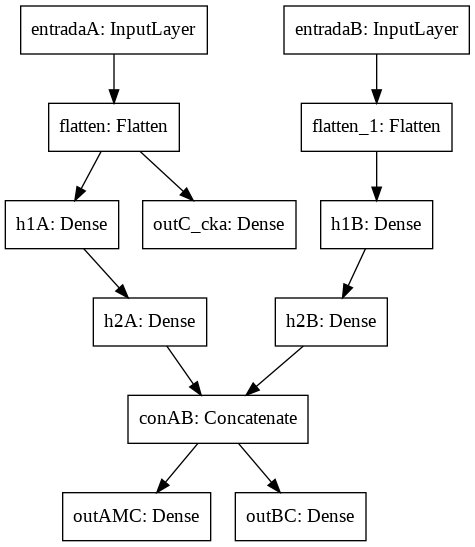

In [15]:
#ejemplo funcional
tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entradaA')
inputB = tf.keras.layers.Input(shape=(XtrainB.shape[1],XtrainB.shape[2]), name='entradaB')
Q1 = 100
Q2 = 20
l1 = 1e-3
l2 = 1e-3
flattenA = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(XtrainB.shape[1],XtrainB.shape[2]))(inputB)

h1A = tf.keras.layers.Dense(Q1,activation='tanh',name='h1A',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(Q2,activation='tanh',name='h1B',
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)

h2A = tf.keras.layers.Dense(Q2,activation='tanh',name='h2A',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1A)
h2B = tf.keras.layers.Dense(Q2,activation='tanh',name='h2B',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1B)

concAB = tf.keras.layers.concatenate([h2A,h2B],name='conAB')

outputA = tf.keras.layers.Dense(10,activation="softmax",name='outAMC')(concAB) #salida multiclase
outputB = tf.keras.layers.Dense(1,activation="sigmoid",name='outBC')(concAB) #salida biclase
outputC = tf.keras.layers.Dense(3,activation="linear",use_bias=False,
                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2),
                                name='outC_cka')(flattenA) #salida rotacion Lineal con cka

model_fun = tf.keras.Model(inputs=[inputA,inputB],outputs=[outputA,outputB,outputC])
model_fun.summary()
tf.keras.utils.plot_model(model_fun)

In [16]:
#compilar modelo y entrenar con funcion propia de perdida

model_fun.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(),tf.keras.losses.BinaryCrossentropy(),
                        custom_loss(scale=5)], 
              loss_weights = [0.3,0.3,0.4],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"]) #f1, precision, recall, crossentropy
history = model_fun.fit(x =[Xtrain,XtrainB], y=[ytrain,ytrainB,ytrain], 
                        epochs=30,batch_size=64, # 32, 64, 128, 256
                         validation_split=0.3)

Epoch 1/30
657/657 [==============================] - 7s 10ms/step - loss: 0.7533 - outAMC_loss: 0.7236 - outBC_loss: 0.3299 - outC_cka_loss: -0.4521 - outAMC_accuracy: 0.8304 - outBC_accuracy: 0.8632 - outC_cka_accuracy: 0.0098 - val_loss: 0.3119 - val_outAMC_loss: 0.5532 - val_outBC_loss: 0.3252 - val_outC_cka_loss: -0.4688 - val_outAMC_accuracy: 0.8565 - val_outBC_accuracy: 0.8662 - val_outC_cka_accuracy: 0.0078
Epoch 2/30
657/657 [==============================] - 6s 9ms/step - loss: 0.2347 - outAMC_loss: 0.4833 - outBC_loss: 0.2471 - outC_cka_loss: -0.4683 - outAMC_accuracy: 0.8719 - outBC_accuracy: 0.9050 - outC_cka_accuracy: 0.0061 - val_loss: 0.1906 - val_outAMC_loss: 0.4406 - val_outBC_loss: 0.2172 - val_outC_cka_loss: -0.4689 - val_outAMC_accuracy: 0.8789 - val_outBC_accuracy: 0.9204 - val_outC_cka_accuracy: 0.0053
Epoch 3/30
657/657 [==============================] - 6s 9ms/step - loss: 0.1734 - outAMC_loss: 0.4304 - outBC_loss: 0.2045 - outC_cka_loss: -0.4675 - outAMC_accur

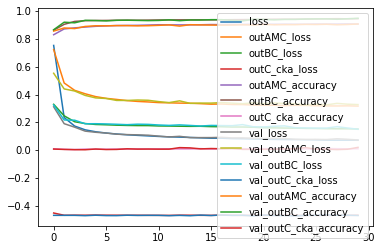

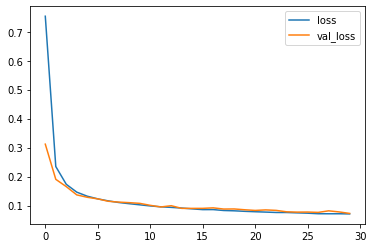

In [17]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

# Evaluar parte intermedia de la red

In [0]:
#crear nuevo modelo con salida parcial
model_cka = tf.keras.Model(inputs=inputA,outputs=model_fun.get_layer('outC_cka').output)
tf.keras.utils.plot_model(model_cka)
zcka = model_cka.predict(Xtrain)

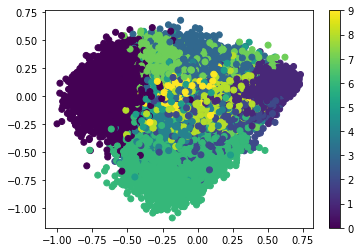

In [19]:
plt.scatter(zcka[:,0],zcka[:,1],c=ytrain)
plt.colorbar()
plt.show()

In [0]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

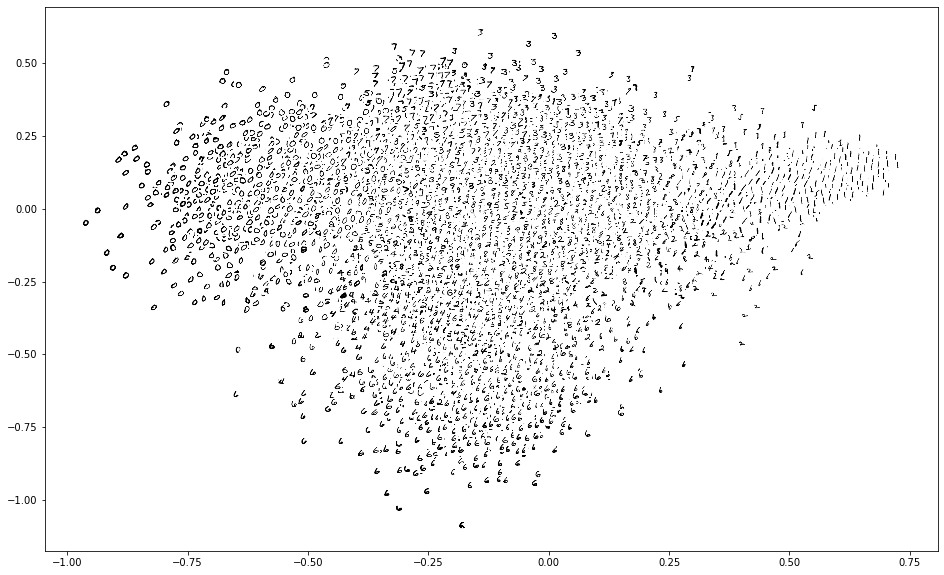

In [21]:
Ni =10000
ind = np.random.randint(0,ytrain.shape[0],Ni)
plot_mnist_2d(zcka[ind],ytrain[ind],Xtrain[ind],img_w=28,img_h=28,zoom=0.3,cmap='binary')

# Wrapper con keras y sklearn





In [0]:
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import StratifiedShuffleSplit

class Keras_CKA(BaseEstimator, TransformerMixin):
  def __init__(self,epochs=30,batch_size=64,Q=2,learning_rate=1e-3,optimizer='Adam',
                l1_param=1e-3,l2_param=1e-3,validation_split=0.2,verbose=1,scale=5):
        self.epochs = epochs
        self.scale = scale
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l2_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.Q=Q
        
  # Define custom loss
  def custom_loss(self):
    #@tf.function()  #decorador para operar sobre python, mas lento y poco efectivo en muchos casos
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_cka_loss(y_true,y_pred): #ytrue labels, ypred  = Xw
      #kernels###############################################
      scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=self.scale)
      scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1e-13)
      k = scalar_kernel.matrix(y_pred, y_pred)
      l = scalar_kernely.matrix(y_true, y_true)
      #centralizar#####################################################
      N = tf.shape(l)[0]
      N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
      h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
      trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
      trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
      trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
      #####funcion de costo############################################3
      f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
      return f
    # Return a function
    return custom_cka_loss

  def fit(self,X,y):
    if self.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif self.optimizer == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    else:
        opt=self.optimizer
    
    tf.keras.backend.clear_session()
    ###acomodar arquitectura de red###### 
    inputA = tf.keras.layers.Input(shape=(X.shape[1],X.shape[2]), name='entradaA')
    flattenA = tf.keras.layers.Flatten(input_shape=(X.shape[1],X.shape[2]))(inputA)
    outputC = tf.keras.layers.Dense(self.Q,activation="linear",use_bias=False,
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param),
                                    name='outC_cka')(flattenA) #salida rotacion Lineal con cka

    self.model = tf.keras.Model(inputs=[inputA],outputs=[outputC])
    self.model.compile(loss=self.custom_loss(), optimizer=opt, metrics = "accuracy")
    self.history = self.model.fit(x =X, y=y,epochs=self.epochs,batch_size=self.batch_size, # 32, 64, 128, 256
                         validation_split=self.validation_split)
    
  def transform(self, X, *_):
    return  self.model.predict(X)
  def fit_transform(self,X,y):
      self.fit(X,y)
      return  self.transform(X)
  def plot_history_acc_w(self):
      plt.plot(self.history.history['loss'],label='loss')
      plt.plot(self.history.history['val_loss'],label='val_loss')
      plt.legend()
      return

In [0]:
red = Keras_CKA()

In [28]:
zcka = red.fit_transform(Xtrain,ytrain)

Epoch 1/30
750/750 [==============================] - 3s 4ms/step - loss: -0.3657 - accuracy: 0.1380 - val_loss: -0.4049 - val_accuracy: 0.1577
Epoch 2/30
750/750 [==============================] - 2s 3ms/step - loss: -0.4114 - accuracy: 0.1770 - val_loss: -0.4365 - val_accuracy: 0.1892
Epoch 3/30
750/750 [==============================] - 3s 3ms/step - loss: -0.4285 - accuracy: 0.1968 - val_loss: -0.4438 - val_accuracy: 0.1941
Epoch 4/30
750/750 [==============================] - 2s 3ms/step - loss: -0.4295 - accuracy: 0.2012 - val_loss: -0.4454 - val_accuracy: 0.1972
Epoch 5/30
750/750 [==============================] - 2s 3ms/step - loss: -0.4314 - accuracy: 0.2039 - val_loss: -0.4455 - val_accuracy: 0.1978
Epoch 6/30
750/750 [==============================] - 2s 3ms/step - loss: -0.4320 - accuracy: 0.2061 - val_loss: -0.4454 - val_accuracy: 0.1992
Epoch 7/30
750/750 [==============================] - 2s 3ms/step - loss: -0.4320 - accuracy: 0.2069 - val_loss: -0.4460 - val_accuracy:

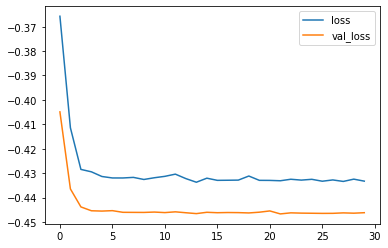

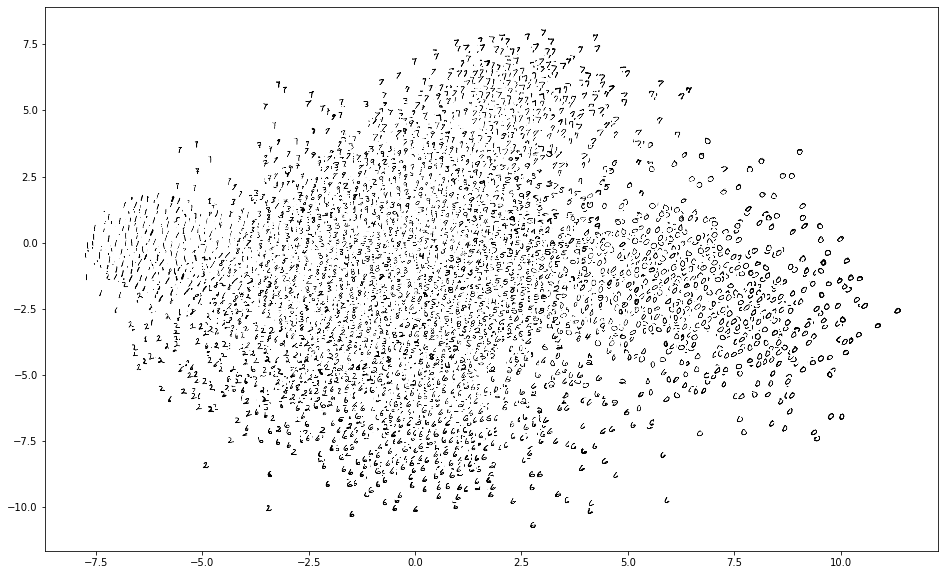

In [29]:
red.plot_history_acc_w()
plt.show()
Ni =10000
ind = np.random.randint(0,ytrain.shape[0],Ni)
plot_mnist_2d(zcka[ind],ytrain[ind],Xtrain[ind],img_w=28,img_h=28,zoom=0.3,cmap='binary')
plt.show()

**Prevenir ser desconectado de Google colab**\

1. Presionar la secuencia Crtl+Shift+i, a continuacion se desplegara una ventana adyacente, en dicha ventana buscar y posteriormente hacer click en la seccion Consola o Console.
2. Una vez allí, en la parte final de la ventana podrá observar un cuadro de texto, por favor introducir el siguiente codigo:
\

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000) 
```
3. Presione posteriormente Enter, luego deberá observar un mensaje que dice "working", en caso de un error introducir el siguiente codigo:
\

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect,60000)
```
